Purpose: 

The purpose of this notebook is to examine the spatially disaggregated model outputs vis-a-vis the mobility patterns seen across Zimbabwe from the original OD matrix. 

We want to see to what extent the infection and deaths that the model predicted according to a beta of (.3?) reflected where in the country saw the highest share of inbound and outbound movement 

Note: it is i5 data that is used in the model


In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt
import geopandas as gpd
import adjustText as aT
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from glob import glob

## 1. Display the spatial disaggregation on mobility data 

In [21]:
# set paths 
from os.path import isfile, join
path = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/'


In [39]:

mobile_i5 = pd.read_csv(path+'analysis/mobility/perc_leave_weekly.csv', sep= ',')
mobile_i5.head()

,objectid,id_0,iso,name_0,id_1,name_1,district_id,dist_name,type_2,engtype_2,nl_name_2,varname_2,comb,weekly_perc_leave_dist
0,1,256,ZWE,Zimbabwe,1,Bulawayo,1,Bulawayo,District,District,NaN,NaN,1-Bulawayo,0.139655
1,2,256,ZWE,Zimbabwe,2,Harare,2,Harare,District,District,NaN,Salisbury|Harare Urban,2-Harare,0.265096
2,3,256,ZWE,Zimbabwe,3,Manicaland,3,Buhera,District,District,NaN,NaN,3-Buhera,0.352465
3,4,256,ZWE,Zimbabwe,3,Manicaland,4,Chimanimani,District,District,NaN,NaN,4-Chimanimani,0.353005
4,5,256,ZWE,Zimbabwe,3,Manicaland,5,Chipinge,District,District,NaN,NaN,5-Chipinge,0.116924


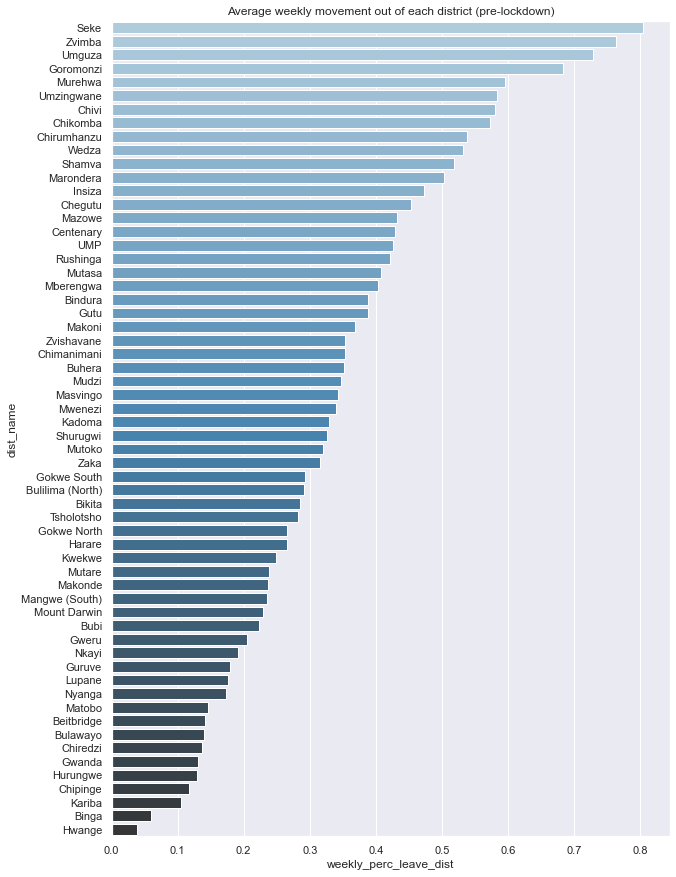

In [40]:
#plot in order seaborn
fig, ax = plt.subplots (figsize = (10, 15))
ax = sns.barplot(x="weekly_perc_leave_dist", 
                 y="dist_name", 
                 palette="Blues_d", 
                 data=mobile_i5, 
                 order=mobile_i5.sort_values('weekly_perc_leave_dist', ascending= False).dist_name
                )
         
# output it
plt.title('Average weekly movement out of each district (pre-lockdown)')
plt.savefig(path+'analysis/mobility/plots/nld_av_weekly_mobility_by_dist.png')



In [6]:
# take a loook at the case data from the 25 perc run from ICCS
cum_cases_25p = pd.read_excel(path+'map_input/cum_cases_num_25p_multidist.xlsx', engine='openpyxl')

#join in the dist names 
cases_plus_mobility = pd.merge(cum_cases_25p, mobile_i5, on='district_id', how='outer')

cases_plus_mobility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 20 columns):
district_id               60 non-null int64
1 cum_cases_sympt25       60 non-null int64
5 cum_cases_sympt25       60 non-null int64
15 cum_cases_sympt25      60 non-null int64
20 cum_cases_sympt25      60 non-null int64
25 cum_cases_sympt25      60 non-null int64
30 cum_cases_sympt25      60 non-null int64
objectid                  60 non-null int64
id_0                      60 non-null int64
iso                       60 non-null object
name_0                    60 non-null object
id_1                      60 non-null int64
name_1                    60 non-null object
dist_name                 60 non-null object
type_2                    60 non-null object
engtype_2                 60 non-null object
nl_name_2                 0 non-null float64
varname_2                 24 non-null object
comb                      60 non-null object
weekly_perc_leave_dist    60 non-null float64
dtypes

In [48]:
pre_post_df = pd.read_csv(path+'analysis/mobility/pre_post_ld_perc_leave_weekly.csv')
pre_post_df.head()

,objectid,id_0,iso,name_0,id_1,name_1,district_id,dist_name,type_2,engtype_2,nl_name_2,varname_2,comb,weekly_perc_leave_dist,ld_weekly_perc_leave_dist,diff_pre_post
0,1,256,ZWE,Zimbabwe,1,Bulawayo,1,Bulawayo,District,District,NaN,NaN,1-Bulawayo,0.139655,0.082493,-0.057162
1,2,256,ZWE,Zimbabwe,2,Harare,2,Harare,District,District,NaN,Salisbury|Harare Urban,2-Harare,0.265096,0.197483,-0.067614
2,3,256,ZWE,Zimbabwe,3,Manicaland,3,Buhera,District,District,NaN,NaN,3-Buhera,0.352465,0.297700,-0.054765
3,4,256,ZWE,Zimbabwe,3,Manicaland,4,Chimanimani,District,District,NaN,NaN,4-Chimanimani,0.353005,0.308750,-0.044254
4,5,256,ZWE,Zimbabwe,3,Manicaland,5,Chipinge,District,District,NaN,NaN,5-Chipinge,0.116924,0.090787,-0.026137


## lolipop plots

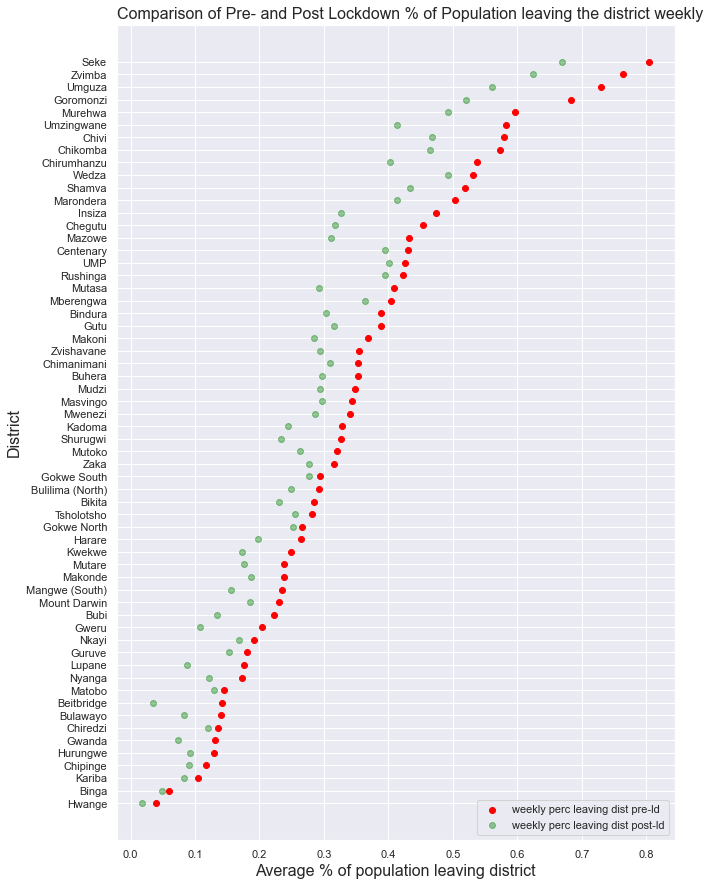

In [61]:
# Reorder it following the values of the first value:
ordered_df = pre_post_df.sort_values(by='weekly_perc_leave_dist')
ordered_df = ordered_df[['district_id', 'dist_name', 'weekly_perc_leave_dist', 'ld_weekly_perc_leave_dist']]

my_range=range(1,len(ordered_df.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_id'], xmin=ordered_df['ld_weekly_perc_leave_dist'], xmax=ordered_df['weekly_perc_leave_dist'], color='grey', alpha=0.4)
plt.scatter(ordered_df['weekly_perc_leave_dist'], my_range, color='red', alpha=1, label='weekly perc leaving dist pre-ld')
plt.scatter(ordered_df['ld_weekly_perc_leave_dist'], my_range, color='green', alpha=0.4 , label='weekly perc leaving dist post-ld')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['dist_name'])
plt.title("Comparison of Pre- and Post Lockdown % of Population leaving the district weekly", loc='left', size = 16)
plt.xlabel('Average % of population leaving district', size = 16)
plt.ylabel('District', size = 16)

# #limit range on axis
# plt.xlim([0, 1])

# # Show the graph
plt.savefig(path+'analysis/mobility/plots/lolipop_pre_post_mobility.png')


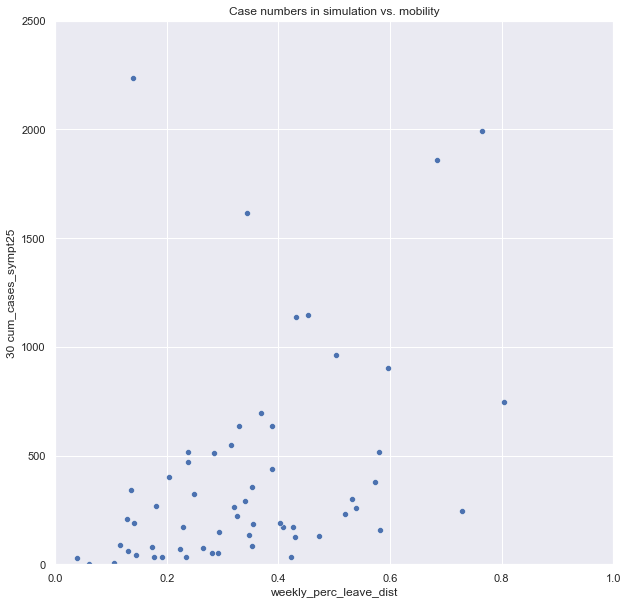

In [7]:
fig, ax = plt.subplots (figsize = (10,10))
ax= sns.scatterplot(
             x="ld_weekly_perc_leave_dist", 
             y="30 cum_cases_sympt25",
             palette="colorblind", 
             data=cases_plus_mobility, #,
            #add labels to points
            )
            #.legend(bbox_to_anchor= (1.03, 1) )
ax.set(xlim=(0, 1), ylim=(0, 2500)) 
plt.title('Case numbers in simulation vs. ld mobility')
plt.savefig(path+'analysis/mobility/plots/cases_vs_ld_mobility.png')

# pretty poor rsquared at present 
 # add labels to values on district id
# for line in range(0,cases_plus_mobility.shape[0]):
#     ax.text(cases_plus_mobility.x[line] +0.01, cases_plus_mobility.y[line],
#            cases_plus_mobility.district_id[line], horizontalalignment='left',
#            size='medium', color='black', weight ='light')
#     ax.set(xlim=(0, 60), ylim=(0, 3000)) 
#     xl, yl = [0,60], [0,3000]
# sns.lineplot(xl, yl, linestyle='--', color='red')


0.0016840121017173137

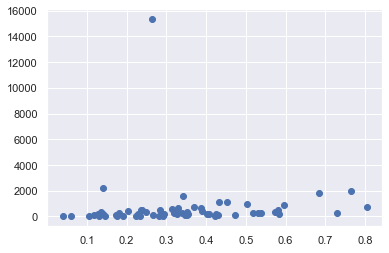

In [15]:

#convert points to format that can be plotted for Rsquared calculation
x=cases_plus_mobility['weekly_perc_leave_dist']
x.to_dict()
y=cases_plus_mobility['30 cum_cases_sympt25']
y.to_dict()

# plot with R-Squared

plt.scatter(x,y)


#fit the line 
model = np.polyfit(x,y,1)
model
predict = np.poly1d(model)
r2_score(y, predict(x))

In [17]:
# remove outliers over 2000 (at position 1 in list)
y = y - [y:[1]]
y

SyntaxError: invalid syntax (<ipython-input-17-cc39376bf71d>, line 2)

In [ ]:
#visualize as scatter and line mobility and case data
x_lin_reg = range(0,140)
y_lin_reg = predict(x_lin_reg)
plt.scatter(x,y, color='blue')
plt.plot(x_lin_reg, y_lin_reg, c='r')
#plt.title("Comparison of Sim and Observed data on First Cases by district", loc='center', size=16)
plt.xlabel('mobility by district', size = 16)
plt.ylabel('tot cases by district day 30 of sim', size = 16)

#limit range on axis
plt.xlim([0, 1])
plt.ylim([0, 2500])

# add labels to values on district id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')
    

# change dimensions of fig size
plt.gcf().set_size_inches(10, 10)
    
plt.savefig(path+'analysis/mobility/plots/mobility_vs_simcases.png', dpi=300,  facecolor='w', edgecolor='w', transparent=True)


In [ ]:
most_mobile_i5 = pd.read_excel(path+'Most mobile districts i5.xlsx', engine='openpyxl')

most_mobile_i5.head()

In [ ]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_cases_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist_med'], color='grey', alpha=0.4)
plt.scatter(ordered_df['true_cases_by_dist'], my_range, color='red', alpha=1, label='total observed cases by district')
plt.scatter(ordered_df['sim_tot_cases_dist'], my_range, color='green', alpha=0.4 , label='total sim cases by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and Observed data on Total Cases by district", loc='left', size = 16)
plt.xlabel('Total cases by District', size = 16)
plt.ylabel('District', size = 16)

#limit range on axis
plt.xlim([0, 12500])

# Show the graph
plt.savefig(path+'plots/district/lolipop_plots/tot_cases_dists_sim_vs_true_exclHarare.png')


### code i didn't end up using 

In [ ]:
dist_names = pd.read_csv(path+'../../../raw/shapefiles/new_districts/ZWE_adm2.csv', sep= ',')
dist_names.head()
# ID_2 is the 60 districts number field, NAME_2 is the merge field
dist_names.rename(columns={'ID_2': 'district_id',
                   'NAME_2': 'dist_name'},
          inplace=True, errors='raise')
dist_names = dist_names.drop_duplicates(subset=['district_id'])
dist_names.head()


# create summary dataset of average mobility by district across all weekdays, so it is collapse by dist_id and weekday taking the average value across weekdays for each dist_id
#df.groupby(['groupvar1', 'groupvar2'])[['var1', 'var2']].mean()

#collapsed = census_5p.groupby(['district_id']).agg({'age':np.mean, 'school_goers':np.sum})

ODM_nld_collapsed = OD_matrix_nld.groupby(['dist_id', 'dist_name']).agg({'d_2':['mean']})
ODM_nld_collapsed.head()

OD_matrix_nld = pd.read_csv(path+'daily_region_transition_probability-new-district-pre-lockdown_i5.csv', sep=',')


#split home_region and create a compatible numeric variable 

OD_matrix_nld[['d','dist_id']] = OD_matrix_nld.home_region.str.split("_", expand=True)

del OD_matrix_nld['d']

OD_matrix_nld['dist_id'] = pd.to_numeric(OD_matrix_nld['dist_id'])

#then want to merge in the name to the dist_id column
OD_matrix_nld = pd.merge(OD_matrix_nld, dist_names, on='dist_id', how='outer')

# reorder columns
cols = OD_matrix_nld.columns.tolist()
print(cols) ## way to get the col list to rearrange
#OD_matrix_nld = OD_matrix_nld[['dist_id', 'home_region', 'NAME_1', 'dist_name', 'weekday',  'd_1', 'd_2', 'd_3', 'd_4', 
#                                'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 
#                                'd_16','d_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 
#                                'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 
#                                'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 
#                                'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60']]
for col in OD_matrix_nld.columns:
     print(col)
OD_matrix_nld.head()